# Report
Feb 13th, 2018

Marc Letourneur

## Introduction
The idea was to work on the headlines published by the Australian news agency ABC from 2003-02-19 to 2017-12-31, hosted on Kaggle https://www.kaggle.com/therohk/million-headlines.

As described in the EDA, a goal could be to for us to unveil some kind of editorial bias on this news agency, by comparing the topics and topic trends with another agencies, might they be from a different country.


## Workflow

This work has been quasi-linear in the sense that I had to loop back accordingly due mainly to local machine limitations & the use of one AWS EC2 instance. For example, I had to go back to previous parts of the flow with new computed features of word2vec, or new indices for the frames.
Yet, the work flow is overall the following:

   1. [eda.ipynb](/notebooks/eda.ipynb)
   
   2. [major_topics.ipynb](/notebooks/major_topics.ipynb)
   
   3. [get pre-trained word2vec.ipynb](/notebooks/get pre-trained word2vec.ipynb)
   
   4. [word2vec_topics_labelling.ipynb](/notebooks/word2vec_topics_labelling.ipynb)
   
   5. [word2vec_similarity_to_headline.ipynb](/notebooks/word2vec_similarity_to_headline.ipynb)
   
I also used some other script to run t-SNE, save and upload files from EC2 to S3 etc.
The content of the repository is described in the README.md stored in the repository.


## Results

#### EDA
In the initial exploratory data analysis ([eda.ipynb](/notebooks/eda.ipynb)), we started with sanity checks:

   The size of the dataset, and the timeline are valid.
    
   Headlines are quite short in average - six words - which is factor of ambiguity/double meaning. This could require advanced disambiguation techniques (for example: distinguigh either a word is used a verb or as a noun) that we have not investigated in this work.  
    
   Almost all days of the entire period are reported. And there is no significant missing data for each day. Indeed, less than 60 days have less than 50 headlines reported (average daily rate is roughly 200 headlines/day).

   This is an important parameter if we are interested in displaying some trends and more generally analyze the dataset with respect to the time dimension.
   Yet, we still can mention that the count of headlines published per year seems a bit unbalanced as displayed in the graph below:
   > the daily publication rate for 2017 is almost half of the one for 2013
   
   Thus, we probably would need to randomly stratify per period (day, month or year) the dataset to compare the trends with another news agency. However, this has not been attempted in this work.
    
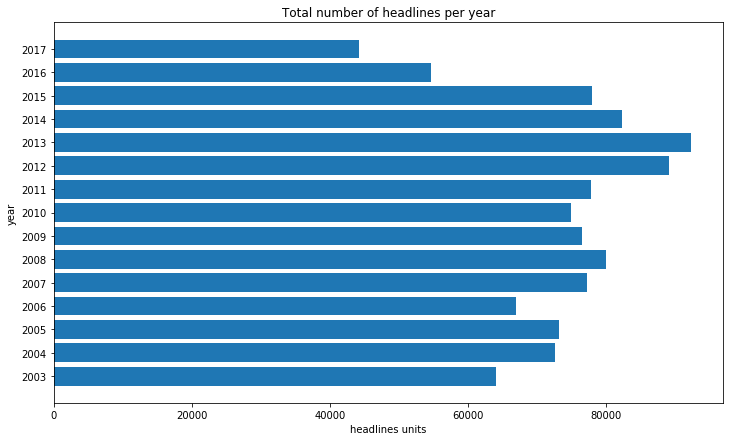

    
#### Topics

Then, the idea was to unveil the topics and the trends for this set ([major_topics.ipynb](/notebooks/major_topics.ipynb))

To get the trend of a topic, we need to label the headlines related to it, and plot the number of headlines versus time.

###### Bag of Words (BoW) model on unigrams

The vocabulary of the dataset is computed, and we get the frequencies of each word.
We can assume topics are correlated with the most frequent words.
We used:
    > from sklearn.feature_extraction.text import CountVectorizer
    
The kernel was dying when attempting to compute the frequency of words, so we applied a 10% sampling to enable the computation. Even with on 10% of the dataset, rule of thumb is that we're going to catch main topics over a month, and so over the whole period.

The stop words (to, in, for etc.) were removed from the BoW model using the built-in list provided by sklearn
We got the following keywords, thus the following broad topics:
    > police, court, charged >> Justice, Police
    > government, plan >> Politics
    > australia, australian, sydney, queensland, western australia >> Australia
    > water >> ?
    > crash, death, health >> Accidents, Health

The BoW representation of the headlines was then derived from the 1000 most frequent words (arbitrary).

###### 2016 US Campaign

The objective is this section was to identify in the corpus the headlines related to the 2016 Trump-Clinton campaign.
We assumed that the list of words below is highly correlated to this topic:

   > key_us = ['american', 'america', 'us', 'usa', 'elections', 'polls', 'poll', 'presidency','president',
   'candidate', 'trump', 'clinton', 'white', 'house', 'running']
   
In order to label the data, we derive a keyword matching scoring: score = number of keyword hits with the headline.
Then idea was to find out the threshold on the score to better classify whether the headlines between two classes:
    > US campaign related
    > other

We had a look at the headlines versus their score to guess a good threshold. The threshold to plot the trend over 2012-2018 is 1 (at least one hit...). The peak is in November 2016, as we would expect, month of elections. 

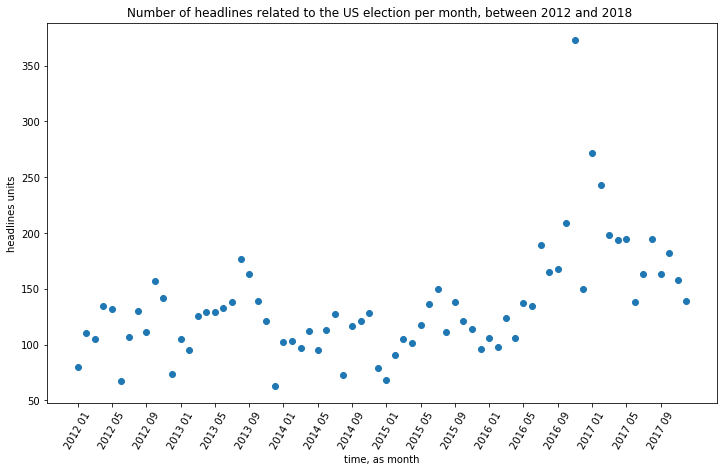

Then, we labelled manually 100 data points and quickly trained a logistic regression model within this BoW space representation of headlines.

_Comments
    1. Keyword matching is doing well to catch relevant headlines with the simple score (number of keyword hits per headline). 

    2. Bag of Words (BoW) space and representation. At this stage, BoW seems to be limited to extract topics and meaning as it is only driven by words frequencies.

    3. We would need to label more data to better assess the performances of BoW in classification.

    4. Add bigrams in this model could be a great improvement.


#### Word2vec

We didn't go deeper with BoW as we wanted to investigate more word2vec models.
This report is already too long, so let's make it brief.

As we suggested earlier, heavy computation was performed to create the word2vec representation of the dataset.
> we used an AWS EC2 machine with augmented memory for some tasks

> still we used only 10% max of the dataset

remark: parallel processing + data engineering (chunk file into files...) + better intuition and common sense would have helped on this part. We didn't go deep into these options.

In our model, the word2vec representation of one headline is the algebraic sum of its words.

We took a pre-trained word2vec model to generate vectors from Google groups: https://code.google.com/archive/p/word2vec/.
> vocabulary size = 300M words, including bigrams.

> gensim python library to handle it

We used [get pre-trained word2vec.ipynb](/notebooks/get pre-trained word2vec.ipynb) to generate the word2vec matrix.

##### 2 approaches with word2vec

 1. The idea was to find the headlines that would hit a topic as defined by a keyword. ([word2vec_topics_labelling.ipynb](/notebooks/word2vec_topics_labelling.ipynb))
Topic was defined by one word - e.g. 'terrorism'.
The flow is:
    * key_topic = 'terrorism'
    * from word2vec model, list the N=50 most similar words (function model.most_similar)
    * compute the score = average of cosine similarities between these words and the headline
    * sort the result by score and apply a threshold to label the dataset

With an arbitrary threshold (based on rule of thumb) we chosed 0.3, we manually labelled the data and plotted the graphical representation of the reduced space with PCA, and t-SNE. 

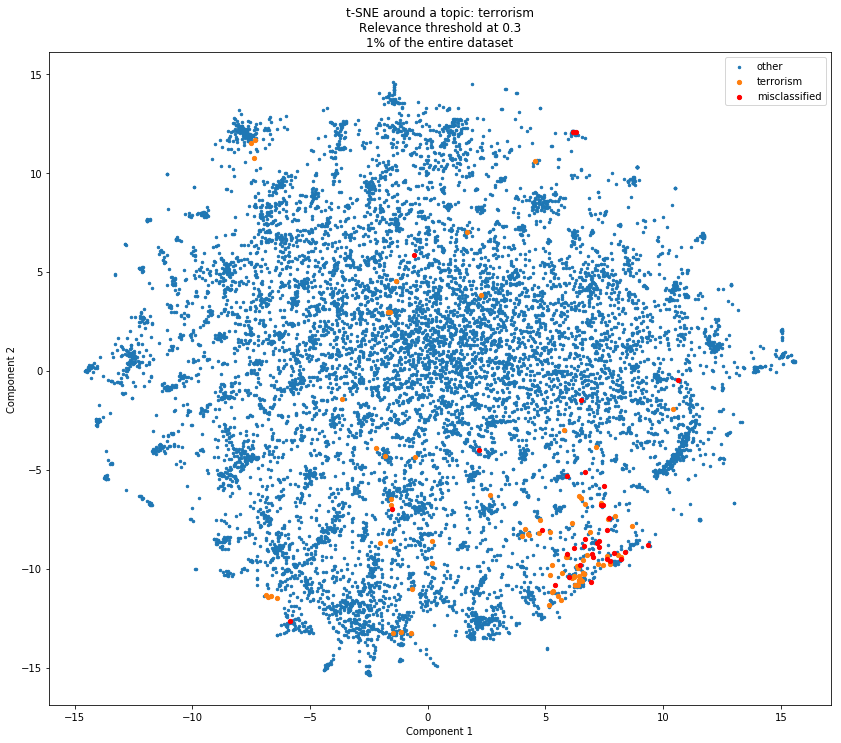

_Comments
    - thresholding is not easy as manual labelling can be also difficult
    - an unsupervised learning scheme might be difficult, but supervised is not if we can label data
    - this is still excluding bigrams
    - the process is really slow on 10% of the dataset: computing score takes 2047 seconds.

 2. Second approach was to find the headlines hitting a topic as it would be defined by another headline/sentence. ([word2vec_similarity_to_headline.ipynb](/notebooks/word2vec_similarity_to_headline.ipynb))
E.g. taking a headline labelled as related to 'terrorism' and see if the similarity score drives us closer to headlines related to 'terrorism'.
    > topic = 'indonesian terrorism expert says jihadists celebrating isis iraq'

The 'similarity' score for a headline h is here the cosinus similarity between the the vector of h and the topic vector.

With an arbitrary threshold that we derived from the previous approach, we labelled and plotted the following reduction with t-SNE.

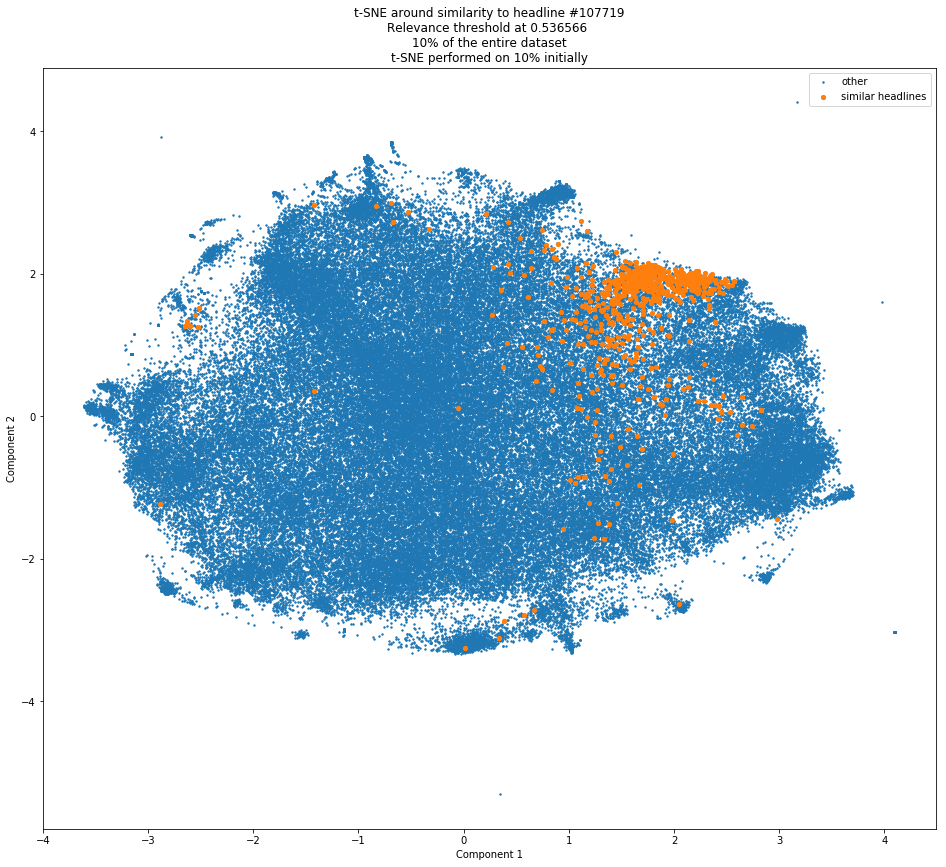


_Comments
    - manual labelling is not straightforward
    - much faster to compute than first approach 

## Conclusion

- We haven't reached the goal of comparing editorial bias between datasets of headlines

- Though we haven't tested it, it seems that word2vec is more powerful than Bag of Words for such topic analysis. Word2vec with bigrams could also be a great improvement

- Data labelling is not a task to neglect on such analysis if we want to try/build models

- I didn't expect the that computational power/optimization would slow down the analysis so much

- t-SNE is a great dimensional reduction technique. Even it is not straightforward to optimize the parameters of the models. We didn'took advantage of it for clustering or classification. The documentation we made is in the repo.


## Ideas

Few ideas that we could try in the short term for such analysis (what I haven't done, what we could do):
- Optimize computation of features in word2vec (memory + CPU)
- Label % of data with broad topics or a specific topic vs the rest: e.g. politics, terrorism, environment
- Explore improvements with bigrams for the computation of word2vec features
- Build a word2vec from scratch with headline datasets only to build domain specific model
- Explore other advanced tools Latent Dirichlet Allocation? GloVe models...

